# Классификация текстов

## Введение

<font color='navy'><b><u>Целевая задача Заказчика</b></u> - для запуска нового сервиса инернет-магазину необходим инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

<Font color='navy'><b><i><u>Цель исследования </b></u>- разработка модели машинного обучения, осуществляющей кассификацию комментариев на позитивные и негативные. Установленный порог качества модели - метрика F1 не менее 0.75 

<Font color='navy'><b><u>Задачи исследования </b></u>- очистка, лемматизация и векторизация текстов, обучение моделей и выбор наилучшей.

<Font color='navy'><b><i><u>План работы</b></i></u><br>
<Font color='navy'>1. загрузка библиотек и данных, обзор данных<br>
<Font color='navy'>2. очистка и лемматизация комментариев<br>
<Font color='navy'>3. векторизация тектсов и формирование признаков<br>
<Font color='navy'>4. обучение и выбор лучшей моедли<br>

## Загрузка и обзор днных

### Загрузка библиотек

In [1]:
# импорт основных библиотек
import pandas as pd
from pymystem3 import Mystem
import numpy as np
import re
import sklearn
import nltk
import spacy
import torch
import transformers
from tqdm.notebook import tqdm
import time
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import warnings
warnings.simplefilter("ignore")

# импорт модулей для работы с текстом
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

nltk.download('wordnet')

# импорт модулей для разделения данных и создания моделей МО
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

 
# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# импорт модулей для расчета метрик
from sklearn.metrics import (recall_score,\
                            precision_score, \
                            accuracy_score, \
                            f1_score, \
                            roc_auc_score, 
                            roc_curve, \
                            confusion_matrix)
from sklearn.utils import shuffle

# импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns


C:\Users\Svetlana\anaconda3\Lib\site-packages\torch\cuda\__init__.py:991: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Svetlana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Снимем ограничения на вывод данных в pandas-таблице
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
# установим константу
RANDOM_STATE = 77

# установим словарь для стоп слов
nltk.download('stopwords') 

# Загружаем английскую языковую модель для spacy
nlp = spacy.load("en_core_web_sm")

STOP_WORDS = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Svetlana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Загрузка и обзор данных

In [8]:
# функция для обзора данных
def display_df_info(data):
    print('\u001b[38;5;19m', '-'*100)
    display(data.head(5))
    print('\u001b[38;5;19m', '-'*100)
    data.info()
    print('\u001b[38;5;19m', '-'*100)
    print('\u001b[38;5;19m', 'Количество столбцов - {}, количество записей - {}'.format(data.shape[1], data.shape[0]))
   
    dupl = data.duplicated().sum()
    if dupl != 0:
        print('\u001b[38;5;19m', 'Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / data.shape[0]))
    else:
        print('\u001b[38;5;19m', 'Дубликаты записей не выявлены')
    
    if data.isnull().sum().sum() != 0:
            def pass_value_barh(data):
                try:
                    (data.isna().mean()*100).to_frame() \
                    .rename(columns = {0:'space'}) \
                    .query('space > 0') \
                    .sort_values(by = 'space', ascending = True) \
                    .plot(kind = 'barh', figsize = (10, 3), legend = False, fontsize = 8, color='royalblue', \
                                   title ='Пропущенные значения, %', \
                                   xlabel = 'Процент пропусков', \
                                   ylabel='Столбцы с пропусками', \
                                   grid=True, style='-',)
                    plt.show();    
                except:
                    print('\u001b[38;5;19m', 'Пропусков данных нет')
    else:
        print('\u001b[38;5;19m', 'Пропусков данных нет')

In [10]:
df = pd.read_csv('C:\\Data_Science\\projects\\Toxic_Text_finder\\toxic_comments.csv', index_col=0)
display_df_info(df)

 ----------------------------------------------------------------------------------------------------


,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


 ----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
 ----------------------------------------------------------------------------------------------------
 Количество столбцов - 2, количество записей - 159292
 Дубликаты записей не выявлены
 Пропусков данных нет


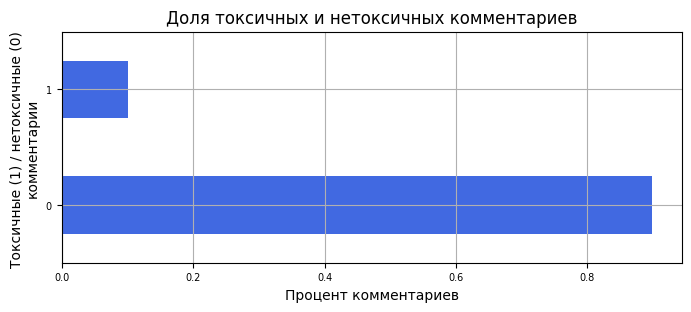

 доля токсичных комментриев составляет - 10.2% всех комментариев датасета


In [11]:
df['toxic'].value_counts(normalize = (0,1))\
            .plot(kind = 'barh', figsize = (8, 3), legend = False, fontsize = 7, color='royalblue', \
                      title ='Доля токсичных и нетоксичных комментариев', \
                      xlabel = 'Процент комментариев', \
                      ylabel='Токсичные (1) / нетоксичные (0) \nкомментарии', \
                      grid=True, style='--',)
plt.show()
print('\u001b[38;5;19m', 'доля токсичных комментриев составляет - {:.1%} всех комментариев датасета'.format(len(df.query('toxic==1'))/len(df['toxic'])))

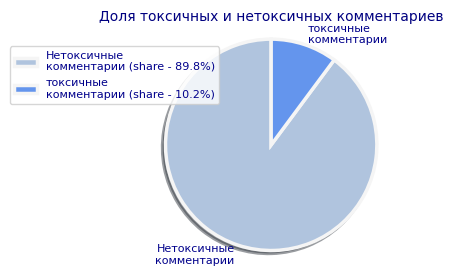

In [12]:
plt.figure(figsize=(3, 3))
labels = ['Нетоксичные\nкомментарии','токсичные\nкомментарии']
values = df['toxic'].value_counts(normalize=True)
total = sum(values)
colors = ['lightsteelblue', 'cornflowerblue']
plt.pie(values, colors=colors, labels=labels, \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 8, 'color': 'darkblue'})
labels = [f"{n} (share - {v/total:.1%})" for n, v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, labelcolor ='darkblue',  fontsize=8)
plt.title('Доля токсичных и нетоксичных комментариев', color='navy', fontsize = 10)
plt.axis('equal')
plt.show()

In [14]:
print('\u001b[38;5;19m', 'Максимальная длина комментария', df['text'].str.len().max())
print('\u001b[38;5;19m', 'Минимальная длина комментария', df['text'].str.len().min())
print('\u001b[38;5;19m', 'Средняя длина комментария', round(df['text'].str.len().mean()))

 Максимальная длина комментария 5000
 Минимальная длина комментария 5
 Средняя длина комментария 394


In [18]:
df['text_len'] = df['text'].str.len()
print('\u001b[38;5;19m', 'Средняя длина негативного комментария - ', round(df.query('toxic == 1')['text_len'].mean()))
print('\u001b[38;5;19m', 'Средняя длина позитивного комментария - ', round(df.query('toxic == 0')['text_len'].mean()))

 Средняя длина негативного комментария -  303
 Средняя длина позитивного комментария -  404


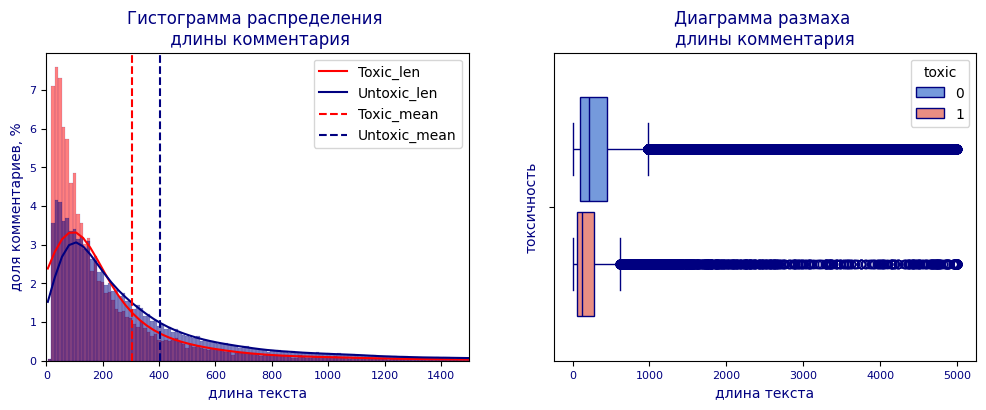

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='text_len', hue='toxic', palette ={0: 'navy', 1: 'red'}, \
                 edgecolor = 'navy', \
                 stat='percent', common_norm=False, kde=True)
toxic_mean_value = df.query('toxic == 1')['text_len'].mean()
untoxic_mean_value = df.query('toxic == 0')['text_len'].mean()
plt.axvline(toxic_mean_value, color='red', linestyle='--')
plt.axvline(untoxic_mean_value, color='navy', linestyle='--')
plt.title(f'Гистограмма распределения \n длины комментария',  fontsize=12, color='navy')
plt.xlabel('длина текста', fontsize=10, color='navy')
plt.ylabel('доля комментариев, %', fontsize=10, color='navy')
plt.yticks(fontsize=8, color='navy')
plt.xlim(0, 1500)
plt.xticks(fontsize=8, color='navy')
plt.legend(['Toxic_len', 'Untoxic_len', 'Toxic_mean', 'Untoxic_mean'])

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='text_len', hue='toxic', 
                palette ={0: 'cornflowerblue', 1: 'salmon'}, fill=True, gap=.1, width=.75, \
                linecolor='navy')
plt.title(f'Диаграмма размаха \nдлины комментария',  fontsize=12, color='navy')
plt.ylabel('токсичность', fontsize=10, color='navy')
plt.xlabel('длина текста', fontsize=10, color='navy')
plt.xticks(fontsize=8, color='navy')
plt.show()

<font color='Darkblue'><b><i>Резюме

<Font color='navy'> Для анализа предоставлен один датасет 159,292 записей и 2 колонки: содержание комментария и его характер (токсичный или нетоксичный)</br>Данные несбалансированы: доля негативных коментариев составляет 10,2% всех комментариев</br>В данных присутствуют аномально длинные комментарии - 5000 знаков.</br>Средняя длина позитивного комментария (404 симовла) на 33,3% превышает среднюю длину негативного<br>Длина оновной части как положительных, так и отрицательных комментариев находится в переделах 1000 символов 

## Очистка и Лемматизация комментариев

In [25]:
# создадим функцию по очистке текста
def clear_text(txt):
    clear_txt = re.sub(r"[^'a-zA-Z ]", ' ', txt).lower() 
    split_txt = clear_txt.split() 
    join_txt = " ".join(split_txt)
    return join_txt

In [27]:
df['clear_text'] = df['text'].apply(clear_text)
df.head()

,text,toxic,text_len,clear_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,264,explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,112,d'aww he matches this background colour i'm seemingly stuck with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,233,hey man i'm really not trying to edit war it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,622,more i can't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it's listed in the relevant form eg wikipedia good article nominations transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,67,you sir are my hero any chance you remember what page that's on


In [28]:
df['clear_txt_len'] = df['clear_text'].str.len()
df.describe()

,toxic,text_len,clear_txt_len
count,"159,292.00","159,292.00","159,292.00"
mean,0.10,393.69,372.14
std,0.30,590.11,560.86
min,0.00,5.00,0.00
25%,0.00,95.00,88.00
50%,0.00,205.00,192.00
75%,0.00,435.00,413.00
max,1.00,"5,000.00","5,000.00"


In [29]:
ubnorm_txt = df.query('clear_txt_len > 1500')['clear_txt_len'].count()
total = df['clear_text'].count()
print('\u001b[38;5;19m', 'В данных представлено {} комментария длиной свыше 1500 слов, что составляет {:.1%} всех записей'.format(ubnorm_txt, ubnorm_txt/total))

 В данных представлено 6043 комментария длиной свыше 1500 слов, что составляет 3.8% всех записей


<Font color='navy'><i>После очистки комментариев от символов длина немного сократилась, но все равно остались выбросы.</br>Для ускорения процессов обработки данных без потери в качестве исключим из датасета комментарии, длиной более 1500 символов

In [34]:
df = df.query('clear_txt_len <= 1500')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153249 entries, 0 to 159450
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           153249 non-null  object
 1   toxic          153249 non-null  int64 
 2   text_len       153249 non-null  int64 
 3   clear_text     153249 non-null  object
 4   clear_txt_len  153249 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.0+ MB


In [36]:
# инициируем леммантайзер
lemmatizer = WordNetLemmatizer()

In [38]:
# сформируем функцию для очистки и лемматизации текста с помощью WordNetLemmatizer() 
def lemm_text(text):
    words_list = nltk.word_tokenize(text)
    lemmatized_txt = ' '.join([lemmatizer.lemmatize(w) for w in words_list])    
    return lemmatized_txt

In [40]:
tqdm.pandas()
start = time.time()
df['lemms_txt'] = df['clear_text'].progress_apply(lemm_text)
end = time.time()
print('\u001b[38;5;19m', 'Время лемматизации - {} секунд'.format(round(end - start, 2)))

  0%|          | 0/153249 [00:00<?, ?it/s]

 Время лемматизации - 182.15 секунд


In [41]:
df['lemm_txt_len'] = df['lemms_txt'].str.len()
df.describe()

,toxic,text_len,clear_txt_len,lemm_txt_len
count,"153,249.00","153,249.00","153,249.00","153,249.00"
mean,0.10,300.76,283.91,281.39
std,0.30,302.07,287.26,284.30
min,0.00,5.00,0.00,0.00
25%,0.00,92.00,85.00,84.00
50%,0.00,194.00,182.00,181.00
75%,0.00,393.00,373.00,369.00
max,1.00,"4,970.00","1,500.00","1,496.00"


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153249 entries, 0 to 159450
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           153249 non-null  object
 1   toxic          153249 non-null  int64 
 2   text_len       153249 non-null  int64 
 3   clear_text     153249 non-null  object
 4   clear_txt_len  153249 non-null  int64 
 5   lemms_txt      153249 non-null  object
 6   lemm_txt_len   153249 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 9.4+ MB


In [46]:
comments = df['clear_text'].tolist()

lemmatized_text = []
# Лемматизируем текст с помощью Scapy
# Использование nlp.pipe для пакетной обработки с отображением прогресса
# "ner", "parser" Отключает компоненты распознавания именованных сущностей и парсинга, т.к. нам нужны только леммы, и ускоряет обработку
start = time.time()
for doc in tqdm(nlp.pipe(comments, disable=["ner", "parser"]), total=len(comments), desc="Лемматизация комментариев"):
    lemmas = [token.lemma_ for token in doc]
    lemmatized_comment = ' '.join(lemmas)
    lemmatized_text.append(lemmatized_comment)
end = time.time()
print('\u001b[38;5;19m', 'Время лемматизации SCAPY - {} секунд'.format(round(end - start, 2)))

df['lemms'] = lemmatized_text

Лемматизация комментариев:   0%|          | 0/153249 [00:00<?, ?it/s]

 Время лемматизации SCAPY - 1475.9 секунд


In [47]:
df['lemms_len'] = df['lemms'].str.len()
df.describe()

,toxic,text_len,clear_txt_len,lemm_txt_len,lemms_len
count,"153,249.00","153,249.00","153,249.00","153,249.00","153,249.00"
mean,0.10,300.76,283.91,281.39,275.25
std,0.30,302.07,287.26,284.30,278.31
min,0.00,5.00,0.00,0.00,0.00
25%,0.00,92.00,85.00,84.00,82.00
50%,0.00,194.00,182.00,181.00,177.00
75%,0.00,393.00,373.00,369.00,361.00
max,1.00,"4,970.00","1,500.00","1,496.00","1,529.00"


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153249 entries, 0 to 159450
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           153249 non-null  object
 1   toxic          153249 non-null  int64 
 2   text_len       153249 non-null  int64 
 3   clear_text     153249 non-null  object
 4   clear_txt_len  153249 non-null  int64 
 5   lemms_txt      153249 non-null  object
 6   lemm_txt_len   153249 non-null  int64 
 7   lemms          153249 non-null  object
 8   lemms_len      153249 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 11.7+ MB


<Font color='navy'><i><b>Резюме

<Font color='navy'>В результате очистки и лемматизации комментариев, а также удаления аномально-длинных комментариев<br>- сформированы токены, пригодные для дальнейшей векторизации<br>- выявлен дисбаланс классов (негативных и позитиных комментраиев), который необходимо учесть при формировании выборок для построения модели

## Построение модели распознавания текстов

### Формирование выборок

In [53]:
data = df.drop(columns=['text',
                         'text_len',
                         'clear_text',
                         'clear_txt_len',
                         'lemms_txt',
                         'lemm_txt_len',
                         'lemms_len'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153249 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   toxic   153249 non-null  int64 
 1   lemms   153249 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [54]:
y = data['toxic']
X = data[['lemms']]
X['lemms'] = X['lemms'].fillna('')

# из-за дисбаланса разбивку на выборки осуществим с использованием стратификации по целевому признаку

# сформируем тренировочную, валидационную и тестовую выборку из сокращенного датасета
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, \
                                                        test_size=0.4, \
                                                        stratify = y, \
                                                        random_state=RANDOM_STATE)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, \
                                                    test_size= 0.5, \
                                                    stratify = y_test_valid, \
                                                    random_state=RANDOM_STATE)

In [55]:
print('\u001b[38;5;19m', 'Размер тренировочной выборки:', X_train.shape)
print('\u001b[38;5;19m', 'Размер валидационной выборки:', X_valid.shape)
print('\u001b[38;5;19m', 'Размер тестовой выборки:', X_test.shape)

 Размер тренировочной выборки: (91949, 1)
 Размер валидационной выборки: (30650, 1)
 Размер тестовой выборки: (30650, 1)


In [56]:
# для исключения фактора несбалансированности выборки применим метод RandomOverSampling для увеличения выборки 
# downsampling ведет к сокращению тренировочной выборки до размеров меньше тестовой и валидационной
sampler = RandomOverSampler(random_state = RANDOM_STATE, sampling_strategy=0.66)
X_train_resample, y_train_resample = sampler.fit_resample(X_train, y_train)
print('\u001b[38;5;19m', 'Размер тренировочной выборки после семплирования:', X_train_resample.shape)

 Размер тренировочной выборки после семплирования: (136956, 1)


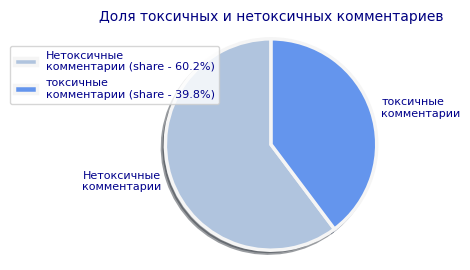

In [57]:
# проверим сбалансрованность классов после семплирования
plt.figure(figsize=(3, 3))
labels = ['Нетоксичные\nкомментарии','токсичные\nкомментарии']
values = y_train_resample.value_counts(normalize=True)
total = sum(values)
colors = ['lightsteelblue', 'cornflowerblue']
plt.pie(values, colors=colors, labels=labels, \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 8, 'color': 'darkblue'})
labels = [f"{n} (share - {v/total:.1%})" for n, v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, labelcolor ='darkblue',  fontsize=8)
plt.title('Доля токсичных и нетоксичных комментариев', color='navy', fontsize = 10)
plt.axis('equal')
plt.show()

<Font color='navy'><i><b>Резюме

<Font color='navy'>С учетом дисбаланса классов, тренировочная, валидационная и тестовая выборки сформированы пропорцией 60 х 20 х 20 с использованием стратификации по целевому признаку<br> Также, для избежания некорректной работы модели на несбаллансированной тренировочной выборке, проведена семплирование (upsampling), в результате которого размер тренировочной выборки увеличился до 136956 записей, а доля токсичных комментраиев увеличена до 40%

### Векторизация комментраиев. Формирование признаков

In [61]:
# создадим "мешок" слов ресемплированных лемм тестовой выборки
count_vect = CountVectorizer(stop_words = STOP_WORDS)
corpus = X['lemms']
bow = count_vect.fit_transform(corpus)
bow.shape

(153249, 127360)

<Font color='navy'><i> Таким образом мы видим, что в анализируемых данных 124,388 уникальных лемм

<Font color='navy'><i>Воспользуемся TfidfVectorizer — для преобразования тескста в числовые векторы с помощью метода TF-IDF, который позволяет выделить наиболее важные слова в тексте. И таким образом сформируем признаки для модели машинного обучения<br>сформируем корпус текстов и векторизуем отедельно каждую выборку

In [64]:
count_tf_idf = TfidfVectorizer(stop_words=STOP_WORDS)

features_train_r = count_tf_idf.fit_transform(X_train_resample['lemms'])
features_train = count_tf_idf.transform(X_train['lemms'])
features_valid = count_tf_idf.transform(X_valid['lemms'])
features_test = count_tf_idf.transform(X_test['lemms'])

print('\u001b[38;5;19m', 'Размер тренировочной выборки признаков после семплирования: ', features_train_r.shape)
print('\u001b[38;5;19m', 'Размер тренировочной выборки признаков без семплирования: ',features_train.shape)
print('\u001b[38;5;19m', 'Размер валидационной выборки признаков: ', features_valid.shape)
print('\u001b[38;5;19m', 'Размер тестовой выборки признаков: ', features_test.shape)

 Размер тренировочной выборки признаков после семплирования:  (136956, 93716)
 Размер тренировочной выборки признаков без семплирования:  (91949, 93716)
 Размер валидационной выборки признаков:  (30650, 93716)
 Размер тестовой выборки признаков:  (30650, 93716)


In [65]:
target_train_r = y_train_resample
target_train = y_train
target_valid = y_valid
target_test = y_test
print('\u001b[38;5;19m', 'Размер тренировочной выборки целевого признака после семплирования: ', target_train_r.shape)
print('\u001b[38;5;19m', 'Размер тренировочной выборки целевого признака без семплирования: ', target_train.shape)
print('\u001b[38;5;19m', 'Размер валидационной выборки целевого признака: ', target_valid.shape)
print('\u001b[38;5;19m', 'Размер тестовой выборки целевого признака: ', target_test.shape)

 Размер тренировочной выборки целевого признака после семплирования:  (136956,)
 Размер тренировочной выборки целевого признака без семплирования:  (91949,)
 Размер валидационной выборки целевого признака:  (30650,)
 Размер тестовой выборки целевого признака:  (30650,)


### Обучение

#### Обучение и выбор лучшей модели

In [68]:
# напишем функцию для подбора параметров модели
def best_model(model, parametrs, features, target):
    model = model
    params = parametrs
    random_search = RandomizedSearchCV(model, params, scoring = 'f1', random_state=RANDOM_STATE, n_jobs = -1, verbose=False)
    random_search.fit(features, target)
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    return best_params, best_score

In [69]:
# в цикле переберем модели, их гиперпараметры и сбалансированный/несбалансированный тренировочные датасеты
models = [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'), \
          LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')]
model_params  = [ 
         {'max_depth': range(2, 15),
         'max_features': range(2, 15),
         'min_samples_split': range(1, 20),
         'min_samples_leaf': range(1, 15)},
    
        {'penalty':['l1','l2','elasticnet','none'],
        'C' : np.logspace(np.log(5), np.log(15), 20),
        'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
        'max_iter'  : [100,1000,2500,5000]}]
#data_mass = [['несбалансированных данных', features_train, target_train], ['сбалансированных данных', features_train_r, target_train_r]]
data_mass = [['несбалансированных данных', features_train, target_train], ['сбалансированных данных', features_train_r, target_train_r]]
for model, parametr in zip(models, model_params):
    for i in tqdm(range(2), desc="Обучение моделей"):
        best_params, best_score =  best_model(model, parametr, data_mass[i][1], data_mass[i][2])
        print('\u001b[34;5;1m', 'на {} для модели {}'.format(data_mass[i][0], model))
        print('\u001b[38;5;19m', '- лучшие параметры {} \n - метрика f1 - {}'.format(best_params, round(best_score, 3)))
        print('\u001b[38;5;19m', '--'*25)

Обучение моделей:   0%|          | 0/2 [00:00<?, ?it/s]

 на несбалансированных данных для модели DecisionTreeClassifier(class_weight='balanced', random_state=77)
 - лучшие параметры {'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 13, 'max_depth': 14} 
 - метрика f1 - 0.188
 --------------------------------------------------
 на сбалансированных данных для модели DecisionTreeClassifier(class_weight='balanced', random_state=77)
 - лучшие параметры {'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 13, 'max_depth': 14} 
 - метрика f1 - 0.571
 --------------------------------------------------


Обучение моделей:   0%|          | 0/2 [00:00<?, ?it/s]

 на несбалансированных данных для модели LogisticRegression(class_weight='balanced', random_state=77)
 - лучшие параметры {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 53.09838489348562} 
 - метрика f1 - 0.754
 --------------------------------------------------
 на сбалансированных данных для модели LogisticRegression(class_weight='balanced', random_state=77)
 - лучшие параметры {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 53.09838489348562} 
 - метрика f1 - 0.974
 --------------------------------------------------


<Font color='navy'><i> Перебор моделей без градиентного бутсинга показал, что наилучшей моделью является модель LogisticRegression с гиперпараметрами {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 1000, 'C': 3792.690190732246}, обученной на сбалансированных методом RandomOverSample тренировочной выборки

In [71]:
# рассчитаем метрику F1 лучшей модели на валидационной выборке
best_model = LogisticRegression(class_weight='balanced', \
                                random_state=RANDOM_STATE, \
                                 solver = 'liblinear', \
                                 penalty ='l2', \
                                 max_iter = 2500, \
                                 C = 4.281332398719396)
best_model.fit(features_train_r, target_train_r)
target_predict_lr = best_model.predict(features_valid)
print('\u001b[34;5;1m', 'Метрика F1 для лушей модели без градиентного бутсинга LogisticRegression на валидационной выборке составляет {}'.format(round(f1_score(target_predict_lr, target_valid),3)))

 Метрика F1 для лушей модели без градиентного бутсинга LogisticRegression на валидационной выборке составляет 0.764


In [72]:
catboost_params = {'loss_function': 'Logloss',  
                    'eval_metric': 'F1',  
                    'verbose': 200,  \
                    'random_seed': RANDOM_STATE}
model_catboost = CatBoostClassifier(**catboost_params, auto_class_weights='Balanced')
model_catboost.fit(features_train_r, target_train_r, eval_set=(features_valid, target_valid), \
                   use_best_model=True,  early_stopping_rounds=1000, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.106818
0:	learn: 0.5250448	test: 0.5263350	best: 0.5263350 (0)	total: 4.9s	remaining: 1h 21m 32s
200:	learn: 0.8986070	test: 0.7789319	best: 0.7789319 (200)	total: 11m 6s	remaining: 44m 8s
400:	learn: 0.9321089	test: 0.7887520	best: 0.7890460 (399)	total: 24m 17s	remaining: 36m 16s
600:	learn: 0.9509407	test: 0.7931529	best: 0.7936887 (597)	total: 33m 45s	remaining: 22m 24s
800:	learn: 0.9653087	test: 0.7970625	best: 0.7974845 (792)	total: 43m 9s	remaining: 10m 43s
999:	learn: 0.9743403	test: 0.7970734	best: 0.7993391 (867)	total: 52m 29s	remaining: 0us

bestTest = 0.7993390728
bestIteration = 867

Shrink model to first 868 iterations.


In [73]:
target_predict_cb = model_catboost.predict(features_valid)
print('\u001b[34;5;1m', 'Метрика F1 для CatBoost на валидационной выборке составляет {}'.format(round(f1_score(target_predict_cb, target_valid),3)))

 Метрика F1 для CatBoost на валидационной выборке составляет 0.757


In [74]:
lgbm_params = {
    'objective': 'binary',
    'metric': 'f1',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'random_seed': RANDOM_STATE}
model_lgbm = LGBMClassifier(**lgbm_params, is_unbalance=True)

model_lgbm.fit(features_train_r, target_train_r)

[LightGBM] [Info] Number of positive: 54452, number of negative: 82504
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 12.540037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412885
[LightGBM] [Info] Number of data points in the train set: 136956, number of used features: 8762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397588 -> initscore=-0.415527
[LightGBM] [Info] Start training from score -0.415527


LGBMClassifier(is_unbalance=True, learning_rate=0.05, metric='f1',
               n_estimators=500, objective='binary', random_seed=77)

In [75]:
target_predict_lgbm = model_lgbm.predict(features_valid)
print('\u001b[34;5;1m', 'Метрика F1 для LGBM на валидационной выборке составляет {}'.format(round(f1_score(target_predict_lgbm, target_valid),3)))

 Метрика F1 для LGBM на валидационной выборке составляет 0.754


<Font color='navy'><i> Из всех рассмотренных моделей лучшая метирка F1 на валидационной выборке равна 0.764 выборке у модели LogisticRegression

#### Лучшая модель на тестовых данных

In [78]:
# рассчитаем прогноз и ключевые метрики для тестовой выборки
target_predict_test = best_model.predict(features_test)
target_proba_test = best_model.predict_proba(features_test)
target_proba_toxic = target_proba_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, target_proba_toxic)
f1_socre = round(f1_score(target_predict_test, target_test), 3)
roc_auc = round(roc_auc_score(target_test, target_proba_toxic), 3)
precision = round(precision_score(target_predict_test, target_test), 3)
recall = round(recall_score(target_predict_test, target_test), 3)

print('\u001b[34;5;1m', f'Показатели качества лучшей модели на тестовой выборке', '\u001b[0m')
print('\u001b[38;5;19m', f'- F1 - {f1_socre}')
print('\u001b[38;5;19m', f'- ROC-AUC - {roc_auc}')
print('\u001b[38;5;19m', f'- precision - {precision}')
print('\u001b[38;5;19m', f'- recall - {precision}')

 Показатели качества лучшей модели на тестовой выборке 
 - F1 - 0.763
 - ROC-AUC - 0.968
 - precision - 0.828
 - recall - 0.828


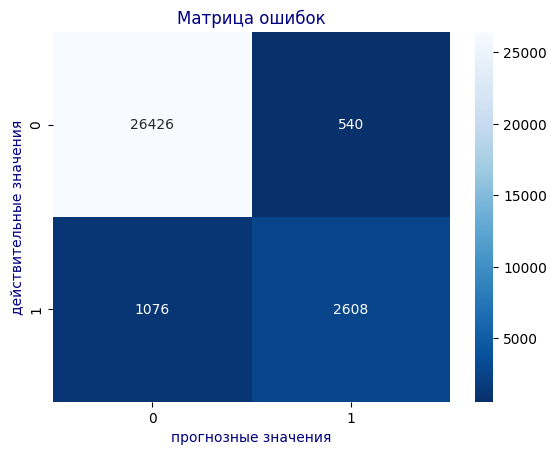

In [79]:
# посмотрим на матрицу ошибок
cm = confusion_matrix(target_predict_test, target_test)
sns.heatmap(cm, annot=True, \
           fmt = 'd', cmap = 'Blues_r')
plt.title('Матрица ошибок', color='navy')
plt.ylabel('действительные значения', color='navy')
plt.xlabel('прогнозные значения', color='navy')
plt.show()

<font color='Darkblue'> Матрица ошибок показывает, что<br><b>✔️ модель допускает ошибку 2го рода (FN)</b> - ошибочно определяет негативный коммент как позитивный<b> 1076 разa</b>,<br>✔️ <b>модель допускает ошибку 1го рода (FP)</b>, т.е. ошибочно определяет позитивный коммент как негативны - <b>540 раз</b>.<br>

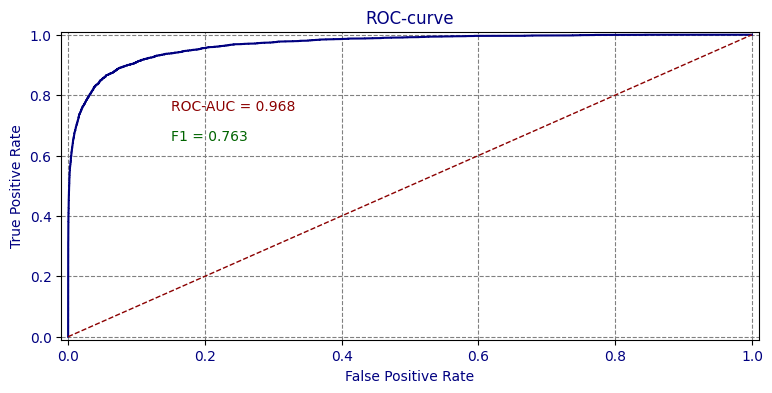

In [81]:
plt.figure(figsize=(9,4))
plt.plot(fpr, tpr, linewidth=1.5, color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, color='darkred')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.text(0.15,0.75,'ROC-AUC = {:.3f}'.format(roc_auc), color='darkred', fontsize=10)
plt.text(0.15,0.65,'F1 = {:.3f}'.format(f1_socre), color='darkgreen', fontsize=10)
plt.xlabel('False Positive Rate', color='navy', fontsize=10)
plt.ylabel('True Positive Rate', color='navy', fontsize=10)
plt.grid(color='grey', linestyle='--')
plt.yticks(fontsize=10, color='navy')
plt.xticks(fontsize=10, color='navy')
plt.title('ROC-curve', color='navy', fontsize=12)

plt.show()

## Выводы

<Font color='navy'>✔️ <b>Целью проекта было найти и обучить модель</b> для магазина "ВИКИШОП", которая способна <b>классифицировать комментарии на позитивные и негативные</b> для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть <b>результата предсказания наилучшей модели по мерке `F1 >= 0.75` 

<Font color='navy'> Для анализа предоставлен один датасет 159,292 записей и 2 колонки: содержание комментария и его характер (токсичный или нетоксичный)</br>&nbsp;&nbsp;&nbsp;- данные несбалансированы: доля негативных коментариев составляет 10,2% всех комментариев</br>&nbsp;&nbsp;&nbsp; - в данных присутствуют аномально длинные комментарии - 5000 знаков.</br>&nbsp;&nbsp;&nbsp; - средняя длина позитивного комментария (404 симовла) на 33,3% превышает среднюю длину негативного<br>Длина оновной части как положительных, так и отрицательных комментариев находится в переделах 1000 символов 

<Font color='navy'>С учетом наличия в данных дисбаланса классов тренировочная, валидационная и тестовая выборки сформированы пропорцией 60 х 20 х 20 с использованием стратификации по целевому признаку<br> Также, для избежания некорректной работы модели на несбаллансированной тренировочной выборке, проведено семплирование (oversampling с пропорцией классов 3:2), в результате которого размер тренировочной выборки увеличился до 136956 записей, а доля токсичных комментраиев увеличена до 40%

<Font color='navy'>Перебор моделей и их гиперпараметров показал, что <b>наилучшая контрольная метрика F1, рассчитанная на валидационных данных, в размере 0.764  формируется у `МОДЕЛИ LOGISTICREGRESSION`</b>

<Font color='navy'><b>Контрольная метрика F1 на тестовых данных лучшей модели LogisticRegression составила 0.763, что выше оперделенного Заказчиком порога.